# How does the output of MCMC vary with dataset properties?
In this notebook I will vary the noise properties of the data (in a massive loop) and collect what happens with the predicted $\sigma$ values.

## 1 Import all the things

In [10]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('..')
from src.scripts import train, models, analysis, utils, dataset_prep

In [3]:
data = dataset_prep.DatasetPreparation(file_path = '../data/') 

In [13]:
x = np.linspace(0,100,101)
parameters = [1, 1, 5]
simulation_name = 'linear'

In [14]:
dataset_manager = dataset_prep.DatasetPreparation('../data/linear.csv')
#dataset_manager.load_data()
#dataset_manager.preprocess_data()

# Simulate linear data
dataset_manager.simulate_data(x, parameters, simulation_name)

# Save the simulated data
#dataset_manager.save_data('simulated_data.csv')

# Access the simulated data
simulated_data = dataset_manager.get_data()
print(simulated_data)

Linear simulation data generated.
     Feature      Target
0        0.0   -0.849421
1        1.0   14.579828
2        2.0   -0.082392
3        3.0    3.876968
4        4.0    6.905666
..       ...         ...
96      96.0   84.021166
97      97.0  101.701648
98      98.0   96.965123
99      99.0   95.497877
100    100.0  102.989764

[101 rows x 2 columns]


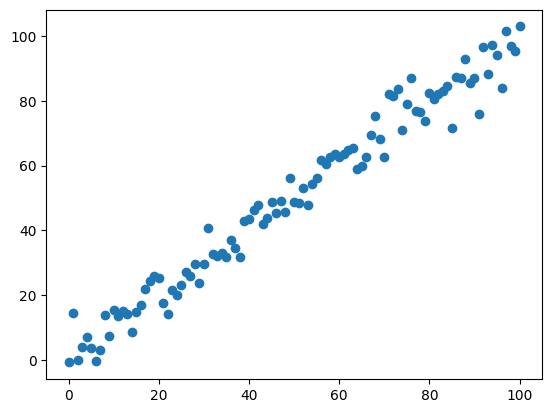

In [15]:
plt.clf()
plt.scatter(simulated_data['Feature'], simulated_data['Target'])
plt.show()

## Define the model

In [28]:
import numpyro

## in numpyro, you must specify number of sampling chains you will use upfront

# words of wisdom from Tian Li and crew:
# on gpu, don't use conda, use pip install
# HMC after SBI to look at degeneracies between params
# different guides (some are slower but better at showing degeneracies)

## define the platform and number of cores (one chain per core)
numpyro.set_platform('cpu')
core_num = 4
numpyro.set_host_device_count(core_num)

import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import jax
import jax.numpy as jnp

In [25]:
def linefit_model(xs,
                  exponential,
                  y=None):
    m = numpyro.sample("m", dist.TruncatedNormal(5, 2, low = 0.01))
    b = numpyro.sample("b", dist.Normal(0, 5))
    σ = numpyro.sample("σ", dist.Exponential(exponential))
    modelx = m * xs + b 
    pos = numpyro.sample("obs", dist.Normal(modelx, σ), obs=y)


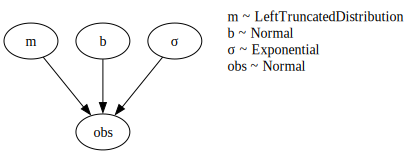

In [26]:
exponential = 100
numpyro.render_model(
    model=linefit_model,
    model_args=(x,exponential),
    render_distributions=True,
    render_params=True,
)

In [31]:
## the NUTS (no u-turn sampler) is a type of hamiltonian monte carlo
## method, meaning it knows about potential energy (think gradients)
nuts_kernel = NUTS(linefit_model, init_strategy = numpyro.infer.initialization.init_to_sample)#, target_accept_prob = 0.9)

# can change the target acceptance probability
# default is 0.8 80% 
mcmc = MCMC(nuts_kernel, num_samples=5000, num_warmup=100, num_chains = 4)
rng_key = jax.random.PRNGKey(0)
mcmc.run(rng_key, x,
                exponential, y = simulated_data['Target'].values)

posterior_samples = mcmc.get_samples()

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

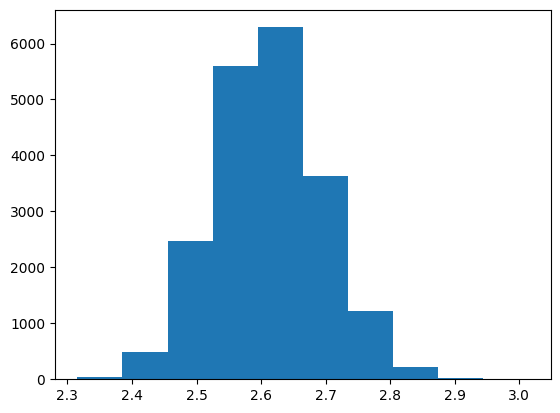

In [33]:
plt.hist(posterior_samples["σ"])
plt.show()

In [36]:
# Do this on a loop for different input sigma values
true_sigmas = np.linspace(0, 10, 10)
mean_sigma = []
for sigma in true_sigmas:
    parameters = [1, 1, sigma]
    dataset_manager.simulate_data(x, parameters, simulation_name)
    simulated_data = dataset_manager.get_data()
    mcmc.run(rng_key,
             x,
             exponential,
             y = simulated_data['Target'].values)
    posterior_samples = mcmc.get_samples()
    mean_sigma.append(np.mean(posterior_samples["σ"]))

Linear simulation data generated.


  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

Linear simulation data generated.


  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

Linear simulation data generated.


  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

Linear simulation data generated.


  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

Linear simulation data generated.


  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

Linear simulation data generated.


  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

Linear simulation data generated.


  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

Linear simulation data generated.


  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

Linear simulation data generated.


  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

Linear simulation data generated.


  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

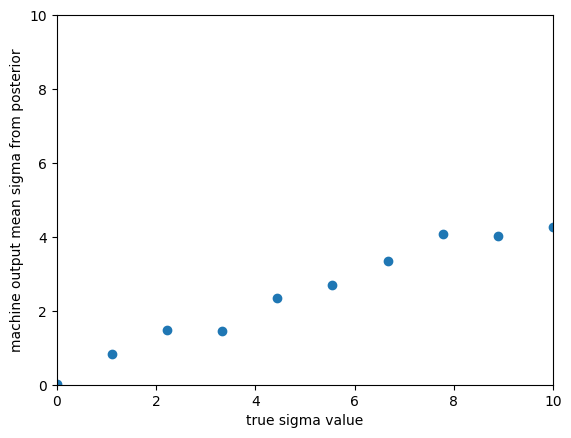

In [39]:
plt.clf()
plt.scatter(true_sigmas, mean_sigma)
plt.xlabel('true sigma value')
plt.ylabel('machine output mean sigma from posterior')
plt.xlim([0,10])
plt.ylim([0,10])
plt.show()